## Exercise 3: Python example 

*Created by Julia Kukulies*

## Part 1: Determining biases 

In [3]:
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import scipy.interpolate

# manage warnings
import warnings 
warnings.filterwarnings('ignore')

In [50]:
# load monthly ocean temperature data 
path ='thetao_Omon_CMCC-CM2-HR4_historical_r1i1p1f1_gn_200001-200112.nc'
oceandata= xr.open_dataset(path)
lonO = oceandata['longitude']
latO = oceandata['latitude']
levO = oceandata['lev']
# select only first entry of the time dimension, to only extract January 2000
thetao = oceandata['thetao'][0,:,:,:]


In [89]:
# find Mariana Trench in 2D latxlon grid
lon1 = 147.5
lon2 = 148.5
lat1 = 14.5
lat2 = 15.5

# get the logical positions (xarray.Dataset.sel only works if coordinates are 1D arrays)
condition_lat= np.logical_and(thetao.latitude >= lat1, thetao.latitude <= lat2)
posMar = np.logical_and(condition_lat.longitude >= lon1, condition_lat.longitude <= lon2)

# extract the corresponding values (output will just set NaN to all values outside your region)
theta_Mar = thetao.where(posMar)

**To select value at 2000 m depth, you can....** 

**Easy: display all depths, look which values are around 2000 and do a weighted mean of theta_Mar**

**Medium: perform a 1D Interpolation with numpy.interp():**

In [141]:
import scipy.interpolate

# perform interpolation along specified axis (here 0 refers to depth levels)
f = scipy.interpolate.interp1d(lev.values, theta_Mar, axis = 0 )
# define new x values
lev_new = np.arange(100,4000,100)
# get y values for new x values based on interpolation function
thetao_new = f(lev_new) 

# temperature at 2000 m:
thetao2000 = thetao_new[19]

**Bringing atmospheric surface temperatures and ocean temperatures to same grid**

In [2]:
# read in daily atmpspheric temperatures 
path = 'ta_day_CMCC-CM2-HR4_historical_r1i1p1f1_gn_20000101-20011231.nc'
dataset = xr.open_dataset(path)
lons = dataset['lon']
lats = dataset['lat']
lev = dataset['plev']
airtemp = dataset['ta']

# extract monthly mean surface temperature for Januray 2000 (output grid has shape 192 x 288)
airJan = np.mean(airtemp.values[0:30, 0, :, :], axis = 0)

In [172]:
# create a regular grid 

loni = np.arange(360)
lati = np.arange(-90,90,1)
# create 2D grid from this (needed for interpolation function)
lon_int, lat_int = np.meshgrid(loni, lati)
# create a 2D grid for atmospheric coordinates 
lon,lat = np.meshgrid(lons,lats)

# use interpolation function 
airJan_int = scipy.interpolate.griddata((lat.flatten(), lon.flatten()), airJan.flatten(), (lat_int, lon_int), method='linear')


(180, 360)


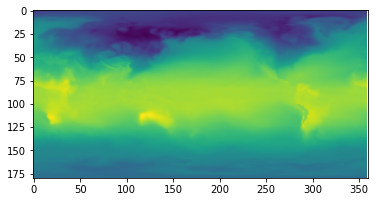

In [49]:
# quick check
print(airJan_int.shape)
plt.imshow(np.flip(airJan_int, axis = 0 ))
plt.show()

In [173]:
# bring ocean temperatures to same grid (this time from irregular to regular grid, same function can be used!)

# extract surface level from ocean depths in Jan 2000
thetaJan = thetao[0, :, :]

# use same interpolation function (takes longer time now)
thetaJan_int = scipy.interpolate.griddata((latO.values.flatten(), lonO.values.flatten()), thetaJan.values.flatten(), (lat_int, lon_int), method='linear')



(180, 360)


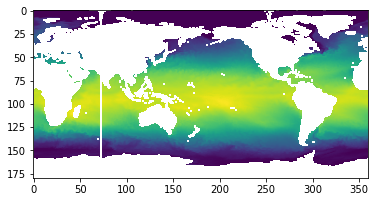

In [175]:
# quick check
print(thetaJan_int.shape)
plt.imshow(np.flip(thetaJan_int, axis = 0 ))
plt.show()

**Now, we want to see how much the ocean and air surface temperatures differ. A few steps need to be done to make the data comparable:**

In [70]:
# for comparison, bring to same unit (air temperatures is in Kelvin )
airJan_int = airJan_int - 273.15

In [74]:
# use the ocean data as a mask to set land data values to NaN with help of fancy indexing: 
mask = np.isnan(thetaJan_int)
airJan_int[mask] = np.nan

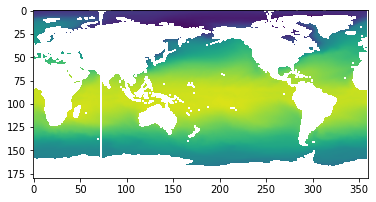

In [80]:
# quick check of differences whether air temperature data has the same land mask now:
plt.imshow(np.flip(airJan_int, axis = 0 ))
plt.show()

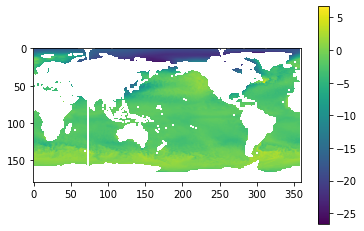

In [81]:
# quick check of differences between the two data arrays: air temperatures - ocean temperatures
difftemp = airJan_int - thetaJan_int
plt.imshow(np.flip(difftemp, axis = 0 ))
plt.colorbar()
plt.show()

In [141]:
# compute RMSE (it is in the name: root mean square...)
rmse = np.sqrt(np.nanmean(difftemp ** 2))

# compute zonal RMSE (that means for each latitude)
rmse_zon = np.zeros(lati.shape)

# looping over latitudes
for ilat in np.arange(lati.shape[0]):
    rmse_zon[ilat] = np.sqrt(np.nanmean(difftemp[ilat, :] ** 2))
    
# alternatively (and more elegantly): just specify dimension over which you want to compute the mean 
rmse_zon = np.sqrt(np.nanmean(difftemp**2, axis = 1))

print('RMSE:', rmse)

RMSE: 7.146313448551237


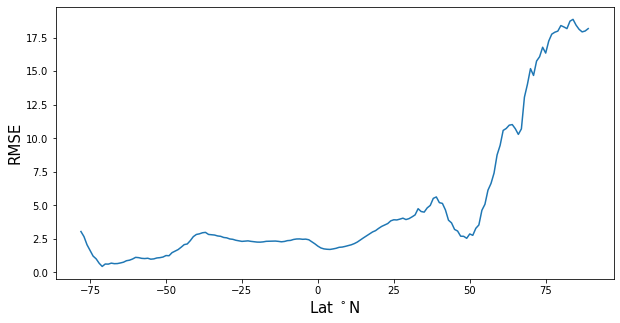

In [158]:
# make a plot 
plt.figure(figsize= (10,5))
s= 15
plt.plot(lati, rmse_zon)
plt.xlabel('Lat $^\circ$N', fontsize= s)
plt.ylabel('RMSE', fontsize= s)
plt.show()

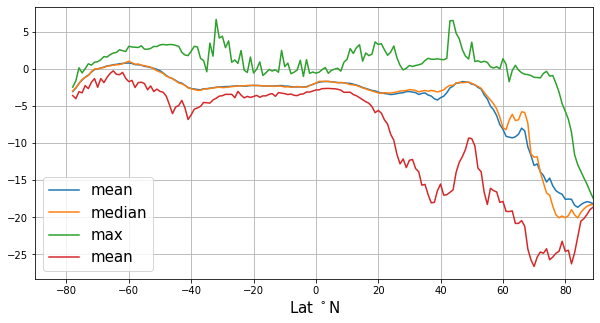

In [163]:
# bonus: do the same for mean, median, minumum and maximum difference 

# for entire grid 
mean = np.nanmean(difftemp)
median = np.nanmedian(difftemp)
maxi = np.nanmax(difftemp)
mini = np.nanmin(difftemp)

# per latitude 
mean_zon = np.nanmean(difftemp, axis = 1)
median_zon = np.nanmedian(difftemp, axis = 1)
max_zon = np.nanmax(difftemp, axis = 1)
min_zon = np.nanmin(difftemp, axis = 1)

# plot (with a bit more extras to make it clear, e.g. add a legend )
plt.figure(figsize= (10,5))

plt.plot(lati, mean_zon, label = 'mean')
plt.plot(lati, median_zon, label = 'median')
plt.plot(lati, max_zon, label = 'max')
plt.plot(lati, min_zon, label = 'mean')

plt.xlim(lati.min(), lati.max())
plt.grid()
plt.xlabel('Lat $^\circ$N', fontsize= s)
plt.legend(fontsize= s)
plt.show()

In [176]:
# you can save your arrays, so you avoid long calculations for preprocessing if you need the data again! 

# save original and interpolated fields for Jan 2000
np.save('airJan', airJan)
np.save('thetaJan', thetaJan)
np.save('airJan_int', airJanJan_int)
np.save('thetaJan_int', thetaJan_int)

# save corresponding coordinates
np.save('latO', latO)
np.save('lonO', lonO)
np.save('lat', lat)
np.save('lon', lon)
np.save('lat_int', lat_int)
np.save('lon_int', lon_int)

## Part 2: Determining variability 

**Fourier transformation of monthly wind speeds**

In [5]:
# read in data of monthly wind speeds (from exercise 1)
path = 'sfcWind_Amon_CMCC-CM2-HR4_historical_r1i1p1f1_gn_185001-201412.nc'
dataset= xr.open_dataset(path)
windspeeds = dataset['sfcWind']

# display to remember dimensions 
display(windspeeds)

<xarray.DataArray 'sfcWind' (time: 1980, lat: 192, lon: 288)>
[109486080 values with dtype=float32]
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    height   float64 ...
Attributes:
    standard_name:  wind_speed
    long_name:      Near-Surface Wind Speed
    comment:        near-surface (usually, 10 meters) wind speed.
    units:          m s-1
    original_name:  U10
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2020-08-26T10:13:32Z altered by CMOR: Treated scalar dime...

In [6]:
# extraction of timeseries (since we need to do the same operation 3 times, it is more elegant and effective to use a function here )

def get_timeseries(lon, lat, data):
    """This function extracts a the grid cell closest to Gothenburg from a global netCDF file. 
    
    Args: 
    lon: longitude value to extract 
    lat: latitude value to extract
    data: dataset as xarray
    
    Returns: 
    xarray Dataset that contains the timeseries for selected grid cell 
    """
    lons = data.lon.values
    lats = data.lat.values
    lon_idx = (np.abs(lons - lon)).argmin()
    lat_idx = (np.abs(lats - lat)).argmin()
    timeseries = dataset.sel(lon=lons[lon_idx]).sel(lat=lats[lat_idx])
    
    return timeseries
    

In [7]:
# Iceland 
wind_Ice = get_timeseries(65, 25, dataset)

# India 
wind_Ind = get_timeseries(20, 80, dataset)

# Peru 
wind_Pac = get_timeseries(260, -10, dataset)


# save the three datasets for later use (this time as xarray dataset and not as numpy array)
# output data is directly saved in netCDF4
xr.save_mfdataset([wind_Ice, wind_Ind, wind_Pac], ['wind_Ice.nc', 'wind_Ind.nc', 'wind_Pac.nc'], mode='w') 

**Help to better understand how to perform a Fourier transformation in Python:**

https://medium.com/@khairulomar/deconstructing-time-series-using-fourier-transform-e52dd535a44e

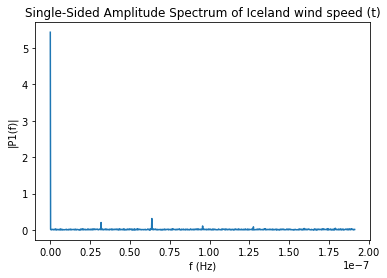

In [5]:
####################### Fourier transformation ############################

###### Define Frequeny and sampling rate ########
T = 30.25*24*3600 # sampling period (one month in seconds)
Fs = 1/T # sampling frequency/sampling rate = average number of samples obtained in a second 
L = np.size(wind_Ice.sfcWind.values) # length of signal
f = Fs*(np.arange(0, L/2))/ L

# apply FFT function 
y_fft = np.fft.fft(wind_Ice.sfcWind.values)
P2 = np.abs(y_fft/L)
P1_Ice = P2[0:np.size(f)]

# plot 
plt.plot(f, P1_Ice)
plt.xlabel('f (Hz)')
plt.ylabel('|P1(f)|')
plt.title('Single-Sided Amplitude Spectrum of Iceland wind speed (t)')
plt.show()


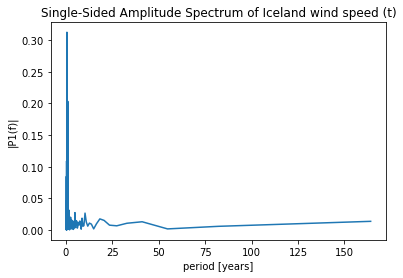

In [291]:
# same but in time domain instead of frequency domain
plt.plot(1/f/(3600*24*365), P1_Ice)
plt.xlabel('period [years]')
plt.ylabel('|P1(f)|')
plt.title('Single-Sided Amplitude Spectrum of Iceland wind speed (t)')
plt.show()

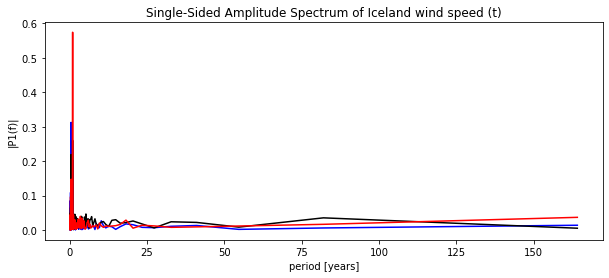

In [6]:
# compute FFT for two other locations and plot over 


# FFT India 
y_fft = np.fft.fft(wind_Ind.sfcWind.values)
P2 = np.abs(y_fft/L)
P1_Ind = P2[0:np.size(f)]

# FFT Peru
y_fft = np.fft.fft(wind_Pac.sfcWind.values)
P2 = np.abs(y_fft/L)
P1_Pac = P2[0:np.size(f)]


# plot 
plt.figure(figsize= (10,4))
plt.plot(1/f/(3600*24*365), P1_Ice, label = 'Iceland', color = 'b')
plt.plot(1/f/(3600*24*365), P1_Ind, label = 'India', color = 'k')
plt.plot(1/f/(3600*24*365), P1_Pac, label = 'Pacific coast', color = 'r')
plt.ylabel('|P1(f)|')
plt.xlabel('period [years]')
plt.title('Single-Sided Amplitude Spectrum of Iceland wind speed (t)')
plt.show()




**Now, we want to remove the seasonal cycle. There are, as always, multiple options to do so. Here are a few examples:**

Tip : The most pythonic way is always to keep your operations as simple and uncomplicated as possible. This is why it make sense to use functions which already exist in packages. However, the advantage of writing your own functions is that you have more control of what actually happens during the calculations. 

In [56]:
# get wind values as numpy array from xarray dataset object: 
wind = wind_Ice.sfcWind.values


# plot function to check what you have calculated 

def check_plot(wind):
    plt.figure(figsize = (20,4))
    plt.plot(wind)
    plt.ylabel('wind (m/s)', fontsize = 18)
    plt.xlabel('time', fontsize = 18)
    plt.show()

**1. Lazy: timestep selection**

Here, of course we display always the same month whos total values are not representative for the entire year. Check how the curve changes, when you start from June instead. 

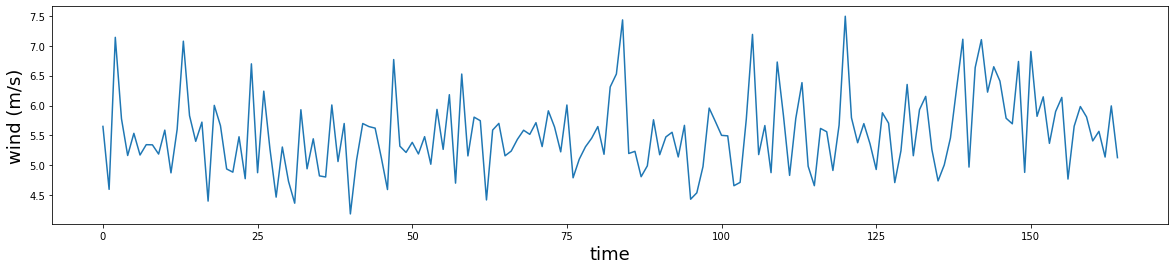

In [52]:
wind_lazy = wind[0:-1:12]

check_plot(wind_lazy)

**2. Easy: yearly means**

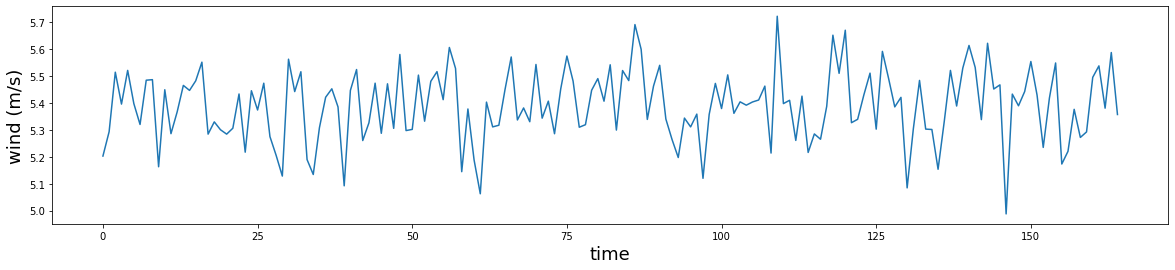

In [27]:
wind_easy = np.empty((int(np.size(wind)/12),))
for iyr in np.arange(np.size(wind)/12):
    # select all wind values for one year
    wind_easy[int(iyr)] = np.nanmean(wind[int(iyr * 12):int((iyr + 1)*12 - 1)])
    
check_plot(wind_easy)

**3. Medium: Compute climatological seasonal cycle and remove it**

This curve looks different, since we remove the seasonal mean from each value. We do not reduce the amount of timesteps like in Examples 1 and 2. 
Look at example 7, where we decompose the timeseries into **trend**, **seasonality** and **residual**. Why does the curve look like the residual curve? 

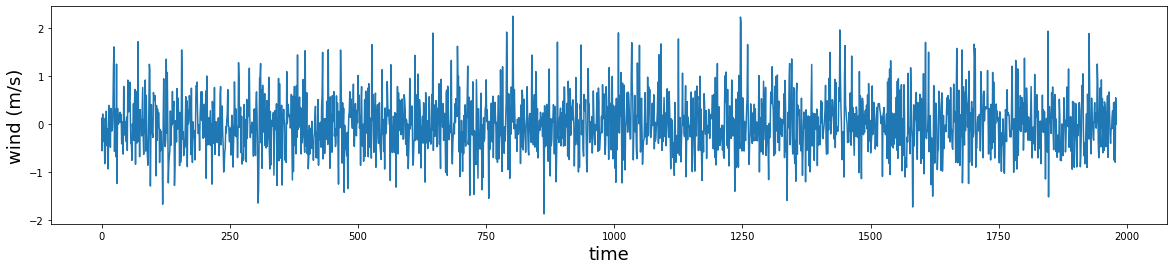

In [58]:
wind_medium = np.empty(np.size(wind))
for imth in np.arange(12):
    # compute mean of each month 
    wind_clim = np.nanmean(wind[imth:-1:12])
    # remove from each value in sfcWind values 
    wind_medium[imth:-1:12] = wind[imth:-1:12] - wind_clim
    

check_plot(wind_medium)

**4. Advanced: Write your own function for smooting through running mean**

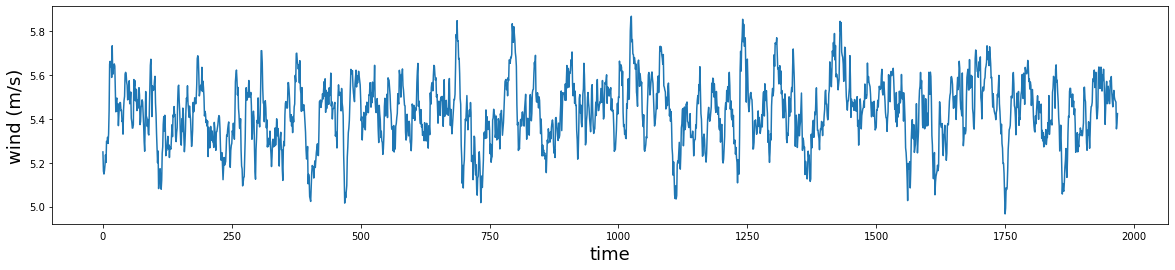

In [29]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

wind_advanced= running_mean(wind, 12)

# plot to check 
check_plot(wind_advanced)

**5. Advanced and lazy: Usint the rolling function of xarray object**

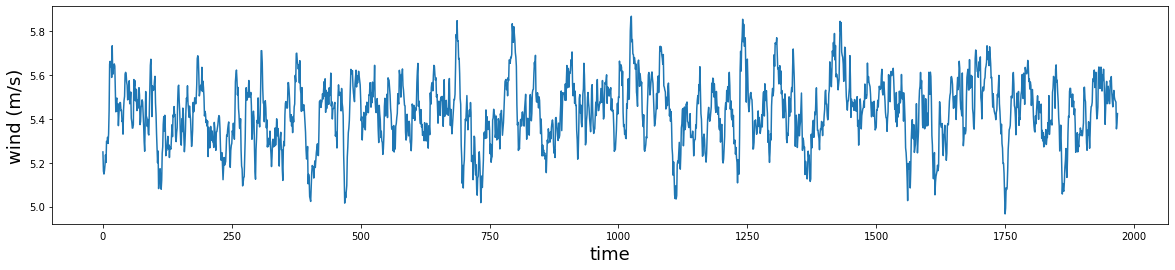

In [31]:
# note that we need for this the xarray data object and not the values as numpy array (which is the variable wind) 
wind_advanced_lazy = wind_Ice.sfcWind.rolling(time=12, center=True).mean().dropna("time")

# plot to check 
check_plot(wind_advanced_lazy)

**6. Boss: Filtering (Smoothing) with convolution**

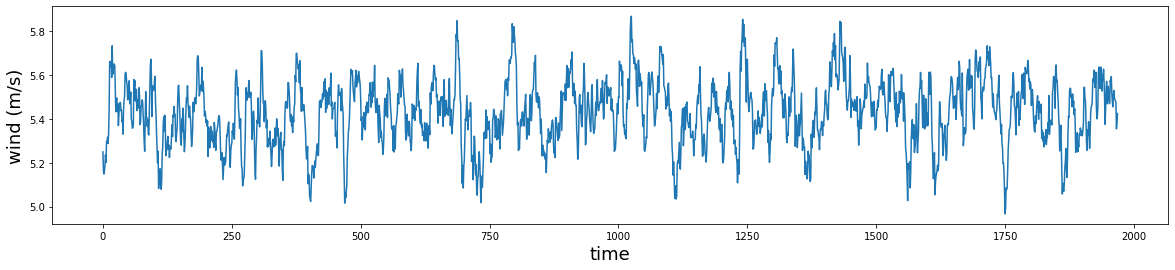

In [32]:
N = 12
wind_boss = np.convolve(wind, np.ones((N,))/N, mode='valid')

# plot to check 
check_plot(wind_boss)

**7. Bossyboss: Decompose your timeseries into trend, seasonal and residual using statsmodels package:**

In [36]:
# you can also install new python packages form here:
!pip install statsmodels

In [43]:
# always check out the documentation of the function to make sure how to use it 
help(seasonal_decompose)

Help on function seasonal_decompose in module statsmodels.tsa.seasonal:

seasonal_decompose(x, model='additive', filt=None, freq=None, two_sided=True, extrapolate_trend=0)
    Seasonal decomposition using moving averages
    
    Parameters
    ----------
    x : array-like
        Time series. If 2d, individual series are in columns.
    model : str {"additive", "multiplicative"}
        Type of seasonal component. Abbreviations are accepted.
    filt : array-like
        The filter coefficients for filtering out the seasonal component.
        The concrete moving average method used in filtering is determined by two_sided.
    freq : int, optional
        Frequency of the series. Must be used if x is not a pandas object.
        Overrides default periodicity of x if x is a pandas
        object with a timeseries index.
    two_sided : bool
        The moving average method used in filtering.
        If True (default), a centered moving average is computed using the filt.
        If F

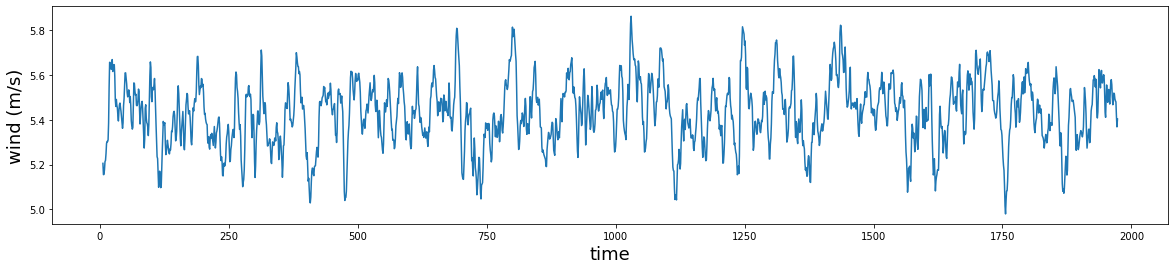

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(wind, model='additative',  freq= 12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# because we removed seasonality, the trend (interannual variability) is what remains
check_plot(trend)

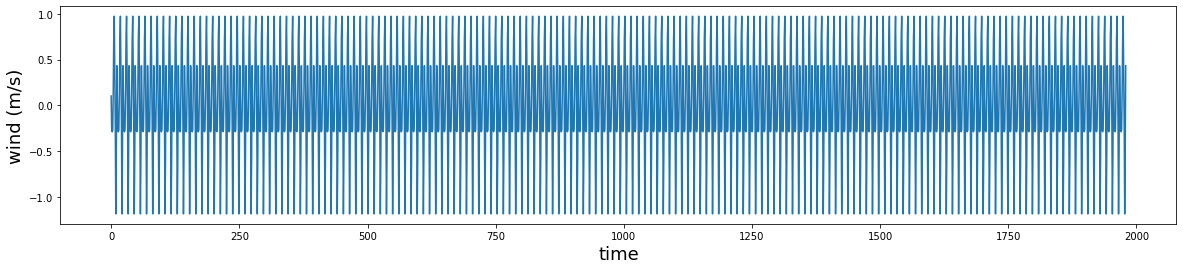

In [46]:
# make also plots of seasonal and residual 
check_plot(seasonal)

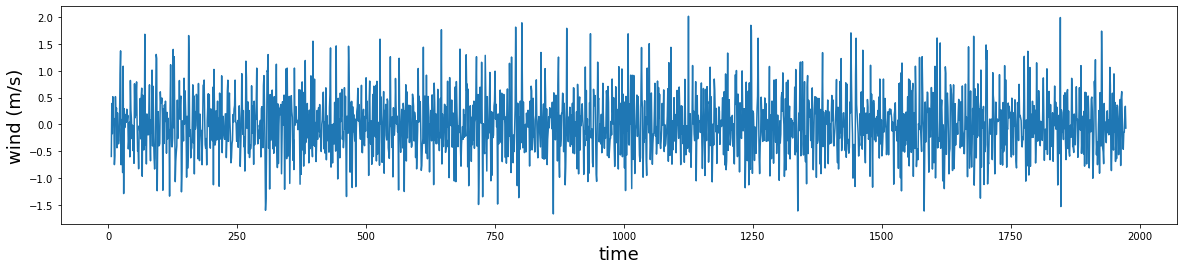

In [47]:
check_plot(residual)

##  Principal component analysis (Empirical Orthogonal Functions)

Read details on the function and look at examples here: 
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

**Why do we need to normalize the data before the PCA?**

The input data has to be normalized because if some values have a large variance and while some are comparatively
small, PCA (which is maximizing variance) will load on the large variances! Test the steps below and see what happens if you leave out the normalization step in the preprocessing. How do the first two principal components look like now? Why do you think, you get such strong eigenvalues in the Southern Ocean? 


In [109]:
from sklearn.decomposition import PCA 
from sklearn.preprocessing import normalize

# step 1: reshape 3D input array to 2D input matrix with  n_features x n_gridpoints (features are time dimension here)
n_features = np.shape(windspeeds)[0]
n_gridpoints = np.shape(windspeeds)[1]*np.shape(windspeeds)[2]
data= np.reshape(windspeeds.values, (n_features,n_gridpoints))
data = data.transpose()

# normalization of input data 
data_norm = normalize(data)

# perform PCA (EOF) on data 
pca = PCA(n_components = 2)
new = pca.fit_transform(data_norm)  
comps= pca.components_

# reshape data space back to grid 
pca1= np.reshape(new[:,0], ((np.shape(windspeeds)[1],np.shape(windspeeds)[2])))
pca2= np.reshape(new[:,1], ((np.shape(windspeeds)[1],np.shape(windspeeds)[2])))


In [110]:
# show explained variance ratio for first and second PCA 
print(pca.explained_variance_ratio_)

[0.40047336 0.08169794]


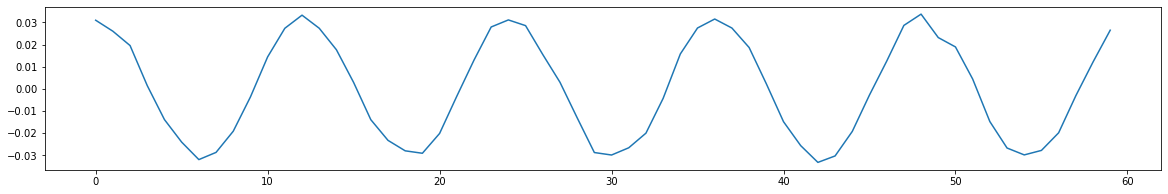

In [112]:
# plot first 5 years of principal axis in feature space (represents maximum variance in data)
plt.figure(figsize= (20,3))
plt.plot(comps[0][0:12*5])
plt.show()

**You can clearly see that PC1 is the seasonal cycle!**

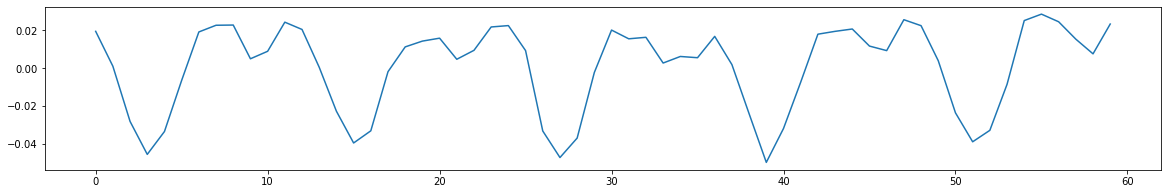

In [113]:
# same for second PCA
plt.figure(figsize=(20,3))
plt.plot(comps[1][0:12*5] )
plt.show()

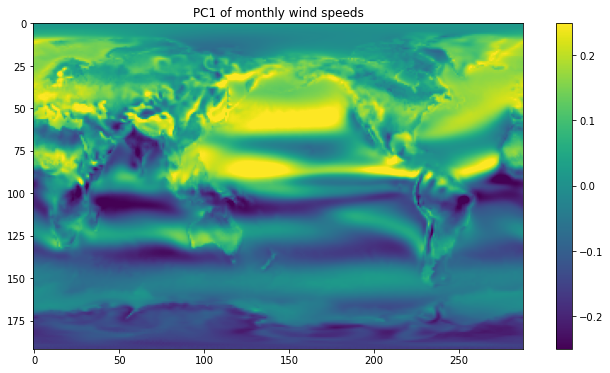

In [116]:
from sklearn import preprocessing

# show map of PCA1 
plt.figure(figsize= (12,6))
plt.title('PC1 of monthly wind speeds')
plt.imshow(np.flip(pca1, axis = 0), vmin = -0.25, vmax = 0.25)
plt.colorbar()
plt.show()

**PCA on detrended data (see options above to remove the seasonal cycle)**

In [117]:
wind_medium = np.empty(np.shape(windspeeds))
for imth in np.arange(12):
    # compute mean of each month 
    wind_clim = np.nanmean(windspeeds[imth:-1:12])
    # remove from sfcWind values 
    wind_medium[imth:-1:12] = windspeeds[imth:-1:12] - wind_clim

In [118]:
# step 1: reshape 3D input array to 2D input matrix with  n_features x n_gridpoints (features are time dimension here)
n_features = np.shape(windspeeds_medium)[0]
n_gridpoints = np.shape(windspeeds_medium)[1]*np.shape(windspeeds_medium)[2]
data= np.reshape(windspeeds_medium, (n_features,n_gridpoints))
data = data.transpose()

# normalization of input data 
data_norm = normalize(data)


# perform PCA (EOF) on data, this time we look at the first 4 components
pca = PCA(n_components = 4)
new = pca.fit_transform(data_norm)  
comps= pca.components_

# reshape data space back to grid 
pca1= np.reshape(new[:,0], ((np.shape(windspeeds)[1],np.shape(windspeeds)[2])))
pca2= np.reshape(new[:,1], ((np.shape(windspeeds)[1],np.shape(windspeeds)[2])))
pca3= np.reshape(new[:,2], ((np.shape(windspeeds)[1],np.shape(windspeeds)[2])))
pca4= np.reshape(new[:,3], ((np.shape(windspeeds)[1],np.shape(windspeeds)[2])))



In [119]:
print(pca.explained_variance_ratio_)

[0.54881576 0.16562999 0.03349608 0.02756527]


**Maps of first four PCA after removal of seasonality:**

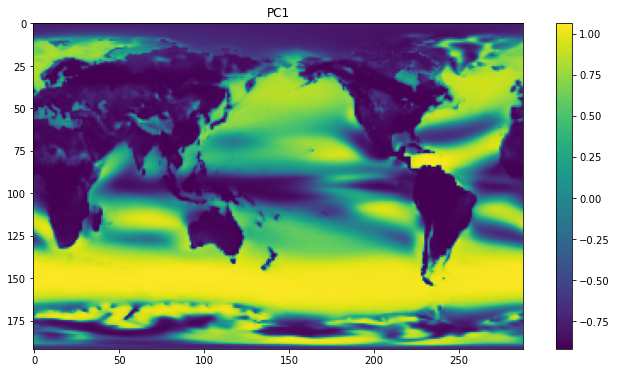

In [130]:
# show map of PC1 a
plt.figure(figsize= (12,6))
plt.title('PC1')
plt.imshow(np.flip(pca1, axis = 0))
plt.colorbar()
plt.show()

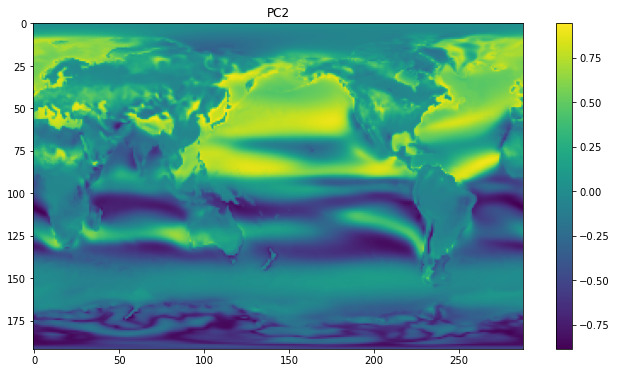

In [123]:
# show map of PC2
plt.figure(figsize= (12,6))
plt.title('PC2')
plt.imshow(np.flip(pca2, axis = 0))
plt.colorbar()
plt.show()

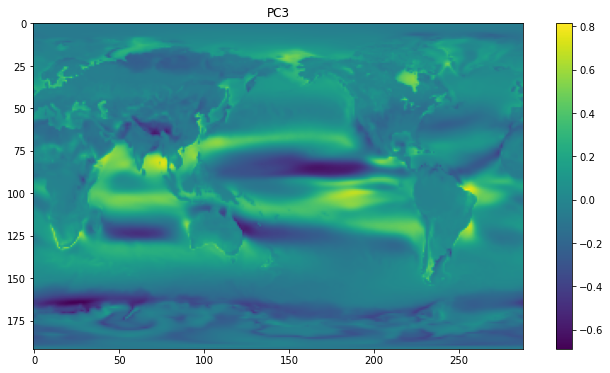

In [125]:
# show map of PC3
plt.figure(figsize= (12,6))
plt.title('PC3')
plt.imshow(np.flip(pca3, axis = 0))
plt.colorbar()
plt.show()

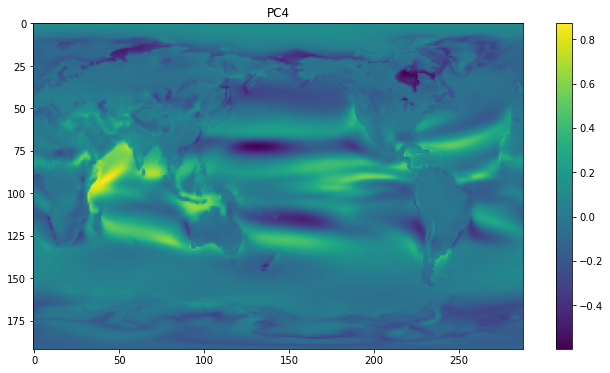

In [127]:
# show map of PC4
plt.figure(figsize= (12,6))
plt.title('PC4')
plt.imshow(np.flip(pca4, axis = 0))
plt.colorbar()
plt.show()

From the maps, it can be seen that PCA1, PCA3 and PCA4 show the Southern Ocean modes of variability (linked to SAM, ENSO)

PCA2: very strong winds around Greenland linked to NAO 